
In this notebook we try the approach of just simply take the complete classifier VGG-19. According to this one, we get feature detection of 1000 different objects. Maybe there are already enough food related object in this database. Even if not, which is likely, we use this approach to get our code Running


# Imports
Execute this before any pipeline step

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import copy
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import torch

from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import models
from torchvision import transforms
from tqdm.notebook import tqdm

In [ ]:
path = "drive/MyDrive/iml/"
#path = "Documents/ETH/FS21/Machinelearning/task4"

In [ ]:
options = ["mobilenet", "resnet", "vgg19"]
model_name = options[1]
feature_path = model_name + "_features.hdf5"

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# Pipeline Step 1
Read all images and save them into hdf5 format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "drive/MyDrive/iml/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Enumerate all image paths

In [ ]:
paths = [os.path.join(path + "food/", f) for f in os.listdir(path + "food/")]
paths.sort()

NameError: ignored

Allocate space for images (we save them as 8-bit arrays to save space)

In [ ]:
imgs = np.empty((10000,3,224,224), dtype='uint8')

Define preprocessing function

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

Rread and process all images

In [ ]:
for (i, img_path) in enumerate(tqdm(paths)):
    img = Image.open(img_path)
    img = preprocess(img)
    img = np.asarray(img, dtype='uint8')
    img = np.moveaxis(img, 2, 0)
    imgs[i] = img

KeyboardInterrupt: ignored

Print sample image

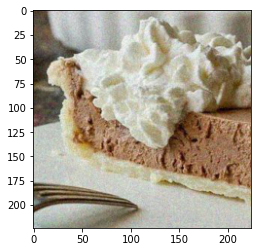

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.moveaxis(imgs[2], 0, 2))

Save all iamges as 8-bit arrays into hdf5 file

In [ ]:
# CAUTION, OVERWRITES FILES!!!

# f = h5py.File(path + "food.hdf5", 'w')
# f.create_dataset("food", data=imgs)

# Pipeline Step 2
Read 8-bit image arrays from hdf5 file. Convert them into float32 arrays and apply normalisation.

In [ ]:
hf = h5py.File(path + "food.hdf5", 'r')
images = hf['food'][:]
# images = torch.from_numpy(images)
preprocess = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
torch_imgs = torch.zeros(10000, 3, 224, 224)
for (i, img) in enumerate(tqdm(images)):
  input_image = Image.fromarray(np.moveaxis(images[i], 0, 2))
  pre = preprocess(input_image)
  torch_imgs[i] = pre

Store the float32 image arrays into an hdf5 file, this requires more storage.

In [ ]:
# CAUTION, OVERWRITES FILES!!!

# images = torch_imgs.numpy()
# f = h5py.File(path + "food_processed.hdf5", 'w')
# f.create_dataset("food", data=images)
# f.close()

# Pipeline Step 3
Pass through pretrained models.

Read the normalised images from the previous step

In [ ]:
#normlized images
hf = h5py.File(path + "food_processed.hdf5", 'r')
images = hf['food'][:]
hf.close()

In [ ]:
images = torch.from_numpy(images)

## Initialise MobileNetV3 model and delete last classification layer

In [ ]:
mobile_net = models.mobilenet_v3_large(pretrained=True)
mobile_net.classifier = nn.Sequential()
mobile_net

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

## Initialise VGG19 model and delete last classification layer

In [ ]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)
# vgg19.classifier = nn.AdaptiveAvgPool2d(output_size=(3, 3))
vgg19.classifier = nn.Sequential()
vgg19

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Initialise ResNet model and delete last classification layer

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
resnet.fc = nn.Sequential()
resnet
# mobile_net.classifier = nn.Sequential()
# mobile_net.to(device)
# mobile_net

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Choose which model to use

In [ ]:
if model_name == "mobilenet":
    model = mobile_net
elif model_name == "resnet":
    model = resnet
elif model_name == "vgg19":
    model = vgg19
model = model.to(device)

Pass all images through model and get features

In [ ]:
n_features = model(images[:1].to(device)).shape[1]

torch.Size([5, 25088])

In [ ]:
model_data = np.zeros((10000, n_features))
with torch.no_grad():
  for i in tqdm(range(200)):
    batch = images[i*50:(i+1)*50].to(device)
    out = model(batch)
    model_data[i*50:(i+1)*50] = out.cpu().numpy()

Store the features in an hdf5 file

In [ ]:
# CAUTION, OVERWRITES FILES!!!

# hf = h5py.File(path + feature_path, 'w')
# hf.create_dataset('features', data=model_data)
# hf.close

<bound method File.close of <HDF5 file "vgg19_features.hdf5" (mode r+)>>

# Pipeline Step 4
Create dataloaders for triplets

Read the image features from the previous pipeline step

In [ ]:
#normlized images
hf = h5py.File(path + feature_path, 'r')
image_features = torch.from_numpy(hf['features'][:])
hf.close()

In [101]:
triplets = np.genfromtxt(path + "train_triplets.txt")
train_triplets = []
val_triplets = []
for triplet in triplets:
    threshold = 5000
    if triplet[0] < threshold and triplet[1] < threshold and triplet[2] < threshold:
        train_triplets.append(triplet)
    elif triplet[0] >= threshold and triplet[1] >= threshold and triplet[2] >= threshold:
        val_triplets.append(triplet)
train_triplets = np.array(train_triplets)
val_triplets = np.array(val_triplets)

In [102]:
test_triplets = np.genfromtxt(path + "test_triplets.txt")

In [103]:
print(train_triplets.shape)
print(val_triplets.shape)

(59515, 3)
(0,)


Create a dataloader which loads either train or test triplets, and stacks all corresponding feature vectors into one vector

In [104]:
class ModelData(Dataset):
  
  def __init__(self, target="train"):
    self.triplets = train_triplets
    if target == "val":
        self.triplets = val_triplets
    elif target == "test":
        self.triplets = test_triplets
    self.num_triplets = self.triplets.shape[0]
    self.features = image_features

  def __len__(self):
    return self.num_triplets

  def __getitem__(self, idx):
    features_anchor = self.features[int(self.triplets[idx,0])]
    features_truthy = self.features[int(self.triplets[idx,1])]
    features_falsy = self.features[int(self.triplets[idx,2])]
    
    x = torch.stack((features_anchor, 
                    features_truthy, 
                    features_falsy),
                    0)
    # y = torch.Tensor([[1]])

    return x

In [105]:
train_data = ModelData()
val_data = ModelData(target="val")
test_data = ModelData(target="test")

Split the dataset into train and validation sets, with ratio 80/20

In [106]:
# train_loader = DataLoader(train_data, batch_size=int(train_size), drop_last=True, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=val_size)
# test_loader = DataLoader(model_test_data, batch_size=len(model_test_data))

In [108]:
train_loader = DataLoader(train_data, batch_size=int(len(train_data)), drop_last=True, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=len(val_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [109]:
x_train = next(iter(train_loader))
# x_val = next(iter(val_loader))
x_test = next(iter(test_loader))

In [110]:
print(x_train.shape)
# print(x_val.shape)
print(x_test.shape)

torch.Size([59515, 3, 512])
torch.Size([59544, 3, 512])


# Pipeline Step 5 (A)
Create model for triplet prediction

In [111]:
class NetTask(nn.Module):

  def __init__(self, n_features):
    super(NetTask, self).__init__()
    self.n_features = n_features

    self.lin1 = nn.Linear(n_features, 512)
    self.lin2 = nn.Linear(512, 256)
    self.lin3 = nn.Linear(256, 10)

    # Define proportion or neurons to dropout
    self.dropout = nn.Dropout(0.6)

  def forward(self, x):
    anchor = x[:, 0, :]
    truthy = x[:, 1, :]
    falsy = x[:, 2, :]

    anchor_out = F.relu(self.lin1(anchor))
    truthy_out = F.relu(self.lin1(truthy))
    falsy_out = F.relu(self.lin1(falsy))

    # anchor_out = F.normalize(anchor_out, p=2, dim=1)
    # truthy_out = F.normalize(truthy_out, p=2, dim=1)
    # falsy_out = F.normalize(falsy_out, p=2, dim=1)

    anchor_out = self.dropout(anchor_out)
    truthy_out = self.dropout(truthy_out)
    falsy_out = self.dropout(falsy_out)

    anchor_out = F.relu(self.lin2(anchor_out))
    truthy_out = F.relu(self.lin2(truthy_out))
    falsy_out = F.relu(self.lin2(falsy_out))

    anchor_out = self.dropout(anchor_out)
    truthy_out = self.dropout(truthy_out)
    falsy_out = self.dropout(falsy_out)

    anchor_out = F.relu(self.lin3(anchor_out))
    truthy_out = F.relu(self.lin3(truthy_out))
    falsy_out = F.relu(self.lin3(falsy_out))

    anchor_out = self.dropout(anchor_out)
    truthy_out = self.dropout(truthy_out)
    falsy_out = self.dropout(falsy_out)

    # anchor_out = F.normalize(anchor_out, p=2, dim=1)
    # truthy_out = F.normalize(truthy_out, p=2, dim=1)
    # falsy_out = F.normalize(falsy_out, p=2, dim=1)
    
    out = torch.stack((
        anchor_out,
        truthy_out,
        falsy_out
    ), 1)

    return out

In [112]:
def accuracy(y_true, y_pred):
  return (sum((y_true == y_pred)*1))/len(y_true)

def compute_label(anchor, truthy, falsy):
  pdist = nn.PairwiseDistance(p=2)
  truthy_dist = pdist(anchor, truthy)
  falsy_dist = pdist(anchor, falsy)
  return (truthy_dist <= falsy_dist) * 1

In [113]:
n_features = x_train.shape[2]
net = NetTask(n_features).to(device)
print(x_train.shape[0])

59515


# Pipeline step 6
Fit the model on the training data, and test it on the validation data. Takes around ??? epochs to train the model.

In [114]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,weight_decay=0.05)
loss_function = nn.TripletMarginLoss(margin=1.0)
epochs = 300
best_accuracy = 0.0
best_model = None
# best_state = net.eval().state_dict()

In [115]:
x_torch = x_train.float().to(device)
for epoch in tqdm(range(epochs)):
    # if epoch % 50 == 0:
    #     x_train = next(iter(train_loader))
    #     x_torch = x_train.float().to(device)
    net.zero_grad()
    optimizer.zero_grad()
    outputs = net(x_torch)
    loss = loss_function(outputs[:, 0, :], outputs[:, 1, :], outputs[:, 2, :])
    loss.backward()
    optimizer.step()
    #     loss = nn.TripletMarginLoss(outputs[0])
    #     loss.backward()
    #     optimizer.step()
    # val_net = net.eval()
    # out = val_net(x_val.float().to(device))
    # out.shape
    # y_predicted = compute_label(out[:, 0, :], out[:, 1, :], out[:, 2, :])
    # y_true = torch.ones(x_val.shape[0])
    # acc = accuracy(y_true, y_predicted.cpu())
    # if acc > best_accuracy:
    #     best_accuracy = acc
    #     best_model = copy.deepcopy(val_net)
    # best_mode
    if epoch % 10 == 0:
        print(f"Loss: {loss}", f"Accuracy: {acc}")

Loss: 1.02727472782135 Accuracy: 0.5424107313156128
Loss: 0.9002063870429993 Accuracy: 0.6830357313156128
Loss: 0.741538941860199 Accuracy: 0.6897321343421936
Loss: 0.7278773188591003 Accuracy: 0.7299107313156128
Loss: 0.7049660086631775 Accuracy: 0.7410714030265808
Loss: 0.6964832544326782 Accuracy: 0.7321428656578064
Loss: 0.6915175318717957 Accuracy: 0.7410714030265808
Loss: 0.6905878782272339 Accuracy: 0.7433035969734192
Loss: 0.6882070302963257 Accuracy: 0.7455357313156128
Loss: 0.6789827346801758 Accuracy: 0.7455357313156128
Loss: 0.6707407236099243 Accuracy: 0.7254464030265808
Loss: 0.6831527948379517 Accuracy: 0.7410714030265808
Loss: 0.6714399456977844 Accuracy: 0.7410714030265808
Loss: 0.6607829332351685 Accuracy: 0.7477678656578064
Loss: 0.6565186977386475 Accuracy: 0.7477678656578064
Loss: 0.6561893820762634 Accuracy: 0.7477678656578064
Loss: 0.6464294791221619 Accuracy: 0.7522321343421936
Loss: 0.6386435627937317 Accuracy: 0.7455357313156128
Loss: 0.6357302665710449 Accura

KeyboardInterrupt: ignored

Save the model weights into a file.

In [ ]:
torch.save(best_model.state_dict(), path + model_name + "_state")
#torch.save(net.state_dict(), path + model_name + "_state")

# Pipeline Step 7
Run the model on the validation dataset and on the test dataset


In [ ]:
model.load_state_dict(torch.load(path + model_name + "_state"))
model = model.eval()
#model.load_state_dict(torch.load(path + model_name + "_state"))
#model = net.eval()

In [128]:
model = best_model.eval()

In [129]:
out = model(x_val.float().to(device))
out.shape

torch.Size([448, 3, 10])

In [130]:
y_predicted = compute_label(out[:, 0, :], out[:, 1, :], out[:, 2, :])

In [131]:
y_true = torch.ones(x_val.shape[0])

In [132]:
accuracy(y_true, y_predicted.cpu())

tensor(0.7701)

In [133]:
out = model(x_test.float().to(device))
y_predicted = compute_label(out[:, 0, :], out[:, 1, :], out[:, 2, :]).cpu()
np.savetxt('submission.txt', y_predicted, fmt='%i')